In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
merged=pd.read_csv("merged_exact.csv")
merged.shape

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_79149/4083409249.py:1: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  merged=pd.read_csv("merged_exact.csv")


(6060, 209)

In [3]:
# Add the median for each fetal growth curve 
brenner = {
    21: 410, 22: 480, 23: 530, 24: 640, 25: 740,
    26: 850, 27: 990, 28:1150, 29:1310, 30:1460,
    31:1630, 32:1810, 33:2010, 34:2220, 35:2430,
    36:2650, 37:2870, 38:3030, 39:3170, 40:3280,
    41:3360, 42:3410, 43:3420, 44:3390
}

who_general = {
    14:  90, 15: 114, 16: 144, 17: 179, 18: 222, 
    19: 272, 20: 330, 21: 398, 22: 476, 23: 565,
    24: 665, 25: 778, 26: 902, 27: 1039, 28: 1189,
    29: 1350, 30: 1523, 31: 1707, 32: 1901, 33: 2103,
    34: 2312, 35: 2527, 36: 2745, 37: 2966, 38: 3186,
    39: 3403, 40: 3617
}

who_female = {
    14:  89, 15: 113, 16: 141, 17: 176, 18: 217, 
    19: 266, 20: 322, 21: 388, 22: 464, 23: 551,
    24: 649, 25: 758, 26: 880, 27: 1014, 28: 1160,
    29: 1319, 30: 1489, 31: 1670, 32: 1861, 33: 2060,
    34: 2268, 35: 2481, 36: 2689, 37: 2917, 38: 3136,
    39: 3354, 40: 3567
}

who_male = {
    14:  92, 15: 116, 16: 146, 17: 183, 18: 226, 
    19: 277, 20: 337, 21: 407, 22: 487, 23: 578,
    24: 681, 25: 795, 26: 923, 27: 1063, 28: 1215,
    29: 1379, 30: 1555, 31: 1741, 32: 1937, 33: 2140,
    34: 2350, 35: 2565, 36: 2783, 37: 3001, 38: 3218,
    39: 3432, 40: 3639
}

intergrowth = {
    18: 216, 
    19: 263, 20: 318, 21: 381, 22: 454, 23: 537,
    24: 630, 25: 734, 26: 851, 27: 979, 28: 1119,
    29: 1272, 30: 1435, 31: 1610, 32: 1795, 33: 1988,
    34: 2189, 35: 2394, 36: 2602, 37: 2811, 38: 3017,
    39: 3217, 40: 3409, 41: 3588
}

## Interpolates 

In [4]:
# Build an interpolation function for each Fetal Growth Curve 
def make_interp(med_map):
    weeks = np.array(sorted(med_map.keys()))            # [14,15,…]
    days  = weeks * 7                                   # [98,105,…] actual days
    meds  = np.array([med_map[w] for w in weeks])       # medians at those weeks

    return lambda gdays: np.interp(gdays, days, meds)   # return the function of f(gdays)

# create one interp‐func per table
interp_brenner    = make_interp(brenner)
interp_who_general= make_interp(who_general)
interp_who_female = make_interp(who_female)
interp_who_male   = make_interp(who_male)
interp_intergrowth   = make_interp(intergrowth)

# Parse GA at delivery and ultrasound into absolute days
# GA at ultrasound is written as 36w 5d
# e.g. “36w 5d” → 36*7 + 5 = 257 days
parsed = merged['best'].str.extract(r'(?P<wk>\d+)\s*[wW]\s*(?P<d>\d+)\s*[dD]', expand=True)
merged['ultra_days'] = parsed['wk'].astype(int)*7 + parsed['d'].astype(int)
# delivery GA are already in days
merged['deliv_days'] = merged['gestday']
    
# Interpolated version of predicted_bw with argument of mode
def compute_predicted_bw_interp(row,mode):
    # pick the right interp‐function
    if mode == 'brenner':
        med_dict,f = brenner,interp_brenner
    elif mode == 'who_general':
        med_dict,f = who_general,interp_who_general
    elif mode == 'intergrowth':
        med_dict,f = intergrowth,interp_intergrowth
    elif mode == 'who_sex':
        if row['sex_of_inf'] == '2:Female':
            med_dict,f = who_female, interp_who_female
        elif row['sex_of_inf'] == '1:Male':
            med_dict,f = who_male,interp_who_male
        else:
            return pd.NA
    else:
        return pd.NA
    
    # handle missing f_weight
    if pd.isna(row['f_weight']) or row['f_weight'] == 0:
        return pd.NA

    # compute the valid day‐range from med_dict
    min_wk, max_wk = min(med_dict), max(med_dict)
    min_day, max_day = min_wk * 7, max_wk * 7

    # if either day is out of range, return NA
    if not (min_day <= row['ultra_days'] <= max_day) or not (min_day <= row['deliv_days'] <= max_day):
        return pd.NA

    # get the median at the exact day
    med_u = f(row['ultra_days'])
    med_d = f(row['deliv_days'])
    
    # apply the GAP formula and return the predicted fetal weight 
    return int(med_d * row['f_weight'] / med_u)


## Sample calculated the predicted Fetal weight using Brenner 

In [5]:
merged['predicted_bw_brenner'] = merged.apply(compute_predicted_bw_interp, axis=1,args=('brenner',)).astype("Int64")

In [12]:
# Count the number of missing values in the interpolated prediction
n_na_brenner = merged['predicted_bw_brenner'].isna().sum()
pct_na_brenner = merged['predicted_bw_brenner'].isna().mean()*100
print(f"Number of NAs in predicted_bw_interp: {n_na_brenner}")
print(f"Percent of NAs in predicted_bw_interp: {pct_na_brenner}")

Number of NAs in predicted_bw_interp: 1307
Percent of NAs in predicted_bw_interp: 22.63203463203463


In [13]:
print( merged['predicted_bw_brenner'].describe() )

count         4468.0
mean     3483.765219
std       511.195155
min           1719.0
25%           3155.0
50%           3476.0
75%           3816.0
max           5915.0
Name: predicted_bw_brenner, dtype: Float64


In [14]:
merged["error_brenner"] = (merged['predicted_bw_brenner'] - merged['birth_wgt'])
merged["error_brenner"].describe()

count        4468.0
mean     113.721576
std      276.182678
min         -1339.0
25%           -61.0
50%           119.0
75%           294.0
max          1288.0
Name: error_brenner, dtype: Float64

In [15]:
merged['abs_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']).abs()
merged['abs_error_brenner'].describe()

count        4468.0
mean     235.501343
std      183.681968
min             0.0
25%            94.0
50%           194.0
75%           336.0
max          1339.0
Name: abs_error_brenner, dtype: Float64

In [16]:
merged['pct_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100
merged["pct_error_brenner"].describe()

count       4468.0
mean       3.81334
std        8.38388
min      -27.26094
25%      -1.769231
50%       3.591036
75%       9.047619
max      44.490501
Name: pct_error_brenner, dtype: Float64

In [17]:
merged['abs_pct_error_brenner']= ((merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100).abs()
merged['abs_pct_error_brenner'].describe()

count       4468.0
mean      7.169674
std       5.780876
min            0.0
25%       2.740375
50%       5.828774
75%      10.340804
max      44.490501
Name: abs_pct_error_brenner, dtype: Float64

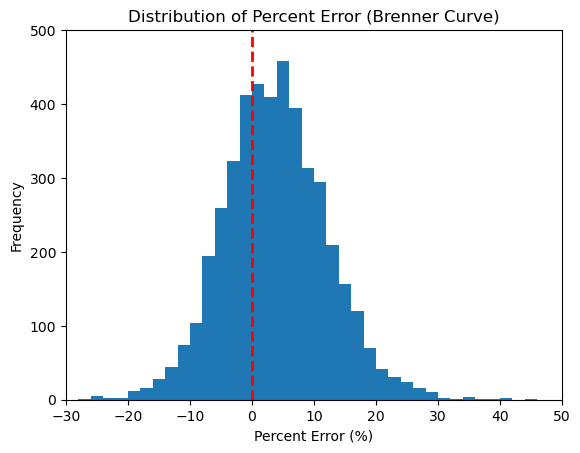

In [50]:
errors = merged['pct_error_brenner'].dropna()
bins = np.arange(-30, 52, 2)
xlim = (-30, 50)
ylim = (0, 500)
# plot histogram
plt.figure()
plt.hist(errors, bins=bins)
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Error (Brenner Curve)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(xlim)                       
plt.ylim(ylim)                       
plt.show()